In [31]:
################ IMPORTS ################
#!pip3 install torch
import torch as torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
#########################################


In [32]:
torch.cuda.empty_cache()

In [33]:
################ Initialising ################
def pcInit():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use if your machine is Windows or Linux
  print(device) # Debugging to check if the device is set up correctly!
  return device


def openSet(defaultPath = True) -> pd.DataFrame:
  """Opens the CSV file using pandas' in-built method"""
  if defaultPath: filepath = "/content/drive/MyDrive/ University/Undergraduate /Year 3/embedded/sem 2/london_weather.csv"
  else: filepath = input("enter file location: ")
  return pd.read_csv(filepath)

device = pcInit()
df = openSet(defaultPath = False)
df
# default path: /content/drive/MyDrive/ University/Undergraduate /Year 3/embedded/sem 2/london_weather.csv
##############################################

cuda:0


KeyboardInterrupt: Interrupted by user

In [ ]:
from posixpath import defpath
################ Data Pre-Processing #############

# Turn the date string objects into actual datetime objects
def dateTimeFmt(df):
  df.loc[:, "date"] = pd.to_datetime(df.loc[:, "date"], format='%Y%m%d')
  #df = df.drop(['date'], axis=1)
  return df

# Function for dealing with n/a observations. mode = ["rmv", "bfill", "ffill", "interpolate"]
# Mode is how the function should deal with the missing data. rmv = remove the instance/datapoint.
#mean = set the n/a observation to the mean value of the feature. For bfill, ffill, and interpolate see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
def naVals(df, mode = "rmv", printNAs = True):
  if printNAs:
    print("Number of N/A observations per feature:")
    print(df.isna().sum())

  # remove the instances
  if mode == "rmv": df.dropna(inplace = True)
  elif mode == "interpolate": 
    if df["snow_depth"].isna().all(): 
      df.fillna(0, inplace=True)
    df.interpolate(method = "linear", inplace = True)
  else: df.fillna(inplace = True, method = mode)

  if printNAs:
    print("After cleaning:")
    print(df.isna().sum())

  return df

# Scales/Normalises & splits the data#
# T = Number of timesteps
def dataScale(df, T = 20):
  size = df.shape[1]
  scaler = StandardScaler()
  scaler.fit(df[:size + T - 1])
  df = scaler.transform(df)
  return df

def dataSplit(df, trainPortion = 0.8, T = 20):
  N = len(df) - T
  trainingSize = int(len(df) * trainPortion)
  setSize = df.shape[1]
  npData = dataScale(df)
  targets = df["mean_temp"].values

  # Train:
  Xtrain = np.zeros((trainingSize, T, setSize))
  Ytrain = np.zeros((trainingSize, 1))

  for t in range(trainingSize):
    Xtrain[t, :, :] = npData[t:t+T]
    Ytrain[t] = (targets[t+T])


  # Test
  print("trainingsize", N - trainingSize)
  print("T", T)
  print("setSize", setSize)
  print("==================================")
  Xtest = np.zeros((N - trainingSize, T, setSize))
  Ytest = np.zeros((N - trainingSize, 1))

  for i in range(N - trainingSize):
    t = i + trainingSize
    Xtest[i, :, :] = npData[t:t+T]
    Ytest[i] = (targets[t+T])


  XTrain = torch.from_numpy(Xtrain.astype(np.float32))
  YTrain = torch.from_numpy(Ytrain.astype(np.float32))
  XTest = torch.from_numpy(Xtest.astype(np.float32))
  YTest = torch.from_numpy(Ytest.astype(np.float32))
  return {
      "datasets": [XTrain, YTrain, XTest, YTest],
      "dimensions": {
          "timesteps": T,
          "dimension": setSize,
          "N": N
          }
      }
#####################################################

def preprocess(df: pd.DataFrame, trainPercent = 0.8, timestep = 20):
  df = dateTimeFmt(df)
  dfDated = df
  df = df.drop(['date'], axis=1)
  df = naVals(df, printNAs = False, mode = "interpolate")
  print(dfDated.shape[0], df.shape[0])
  vars = dataSplit(df, trainPortion = trainPercent, T = timestep)
  vars["dfDated"] = dfDated
  vars["df"] = df
  #df.to_csv("london_weather.csv", index = False)
  return vars

vars = preprocess(df)
XTrain, YTrain, XTest, YTest = vars["datasets"][0], vars["datasets"][1], vars["datasets"][2], vars["datasets"][3]
T, D, N = vars["dimensions"]["timesteps"], vars["dimensions"]["dimension"], vars["dimensions"]["N"]
dfDated = vars["dfDated"]

15341 15341
trainingsize 3049
T 20
setSize 9


In [ ]:
################ Performance Metrics ################

#####################################################

In [52]:
#################### Model ####################

class lstmAlgorithm(nn.Module):
  def __init__(self, inputD, hiddenD, layerD, outputD):
    super(lstmAlgorithm, self).__init__()
    self.M = hiddenD
    self.L = layerD

    self.rnn = nn.LSTM(input_size = inputD, hidden_size = hiddenD, num_layers = layerD, batch_first = True)

    self.fc = nn.Linear(hiddenD, outputD)
  
  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

  def train(self, learningRate, XTrain, YTrain, XTest, YTest, epochs = 200):
    # Loss and optimiser
    criterion = nn.MSELoss()
    optimiser = torch.optim.SGD(self.parameters(), lr = learningRate, momentum = 0.9, weight_decay = 1e-4)

    trainLosses = np.zeros(epochs)
    testLosses = np.zeros(epochs)

    for epoch in range(epochs):
      optimiser.zero_grad()

      # Forward pass
      outputs = self(XTrain)
      loss = criterion(outputs, YTrain)

      # Backpropagation
      loss.backward()
      optimiser.step()

      # Train loss
      trainLosses[epoch] = loss.item()

      # Test loss
      testOutputs = self(XTest)
      testLoss = criterion(testOutputs, YTest)
      testLosses[epoch] = testLoss.item()

      if (epoch + 1) % 10 == 0:
        print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {testLoss.item():.3f}')

    return trainLosses, testLosses

In [ ]:
lstmModel = lstmAlgorithm(D, 512, 2, 1)
lstmModel.to(device)


lstmAlgorithm(
  (rnn): LSTM(9, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
# move data to gpu
XTrain, YTrain = XTrain.to(device), YTrain.to(device)
XTest, YTest = XTest.to(device), YTest.to(device)

In [ ]:
trainLosses, testLosses = lstmModel.train(0.01, XTrain, YTrain, XTest, YTest, epochs = 750)

At epoch 10 of 750, Train Loss: 21.871, Test Loss: 27.517
At epoch 20 of 750, Train Loss: 10.855, Test Loss: 8.195
At epoch 30 of 750, Train Loss: 8.370, Test Loss: 5.058
At epoch 40 of 750, Train Loss: 4.161, Test Loss: 2.534
At epoch 50 of 750, Train Loss: 1.547, Test Loss: 2.153
At epoch 60 of 750, Train Loss: 1.337, Test Loss: 1.737
At epoch 70 of 750, Train Loss: 1.287, Test Loss: 1.487
At epoch 80 of 750, Train Loss: 1.211, Test Loss: 1.451
At epoch 90 of 750, Train Loss: 1.180, Test Loss: 1.423
At epoch 100 of 750, Train Loss: 1.154, Test Loss: 1.408
At epoch 110 of 750, Train Loss: 1.138, Test Loss: 1.393
At epoch 120 of 750, Train Loss: 1.125, Test Loss: 1.381
At epoch 130 of 750, Train Loss: 1.114, Test Loss: 1.371
At epoch 140 of 750, Train Loss: 1.105, Test Loss: 1.364
At epoch 150 of 750, Train Loss: 1.096, Test Loss: 1.356
At epoch 160 of 750, Train Loss: 1.198, Test Loss: 1.456
At epoch 170 of 750, Train Loss: 1.088, Test Loss: 1.379
At epoch 180 of 750, Train Loss: 1.08

In [ ]:
# Save model
torch.save(lstmModel, "lstm.pt")
torch.save(lstmModel.state_dict(), "LSTM_weights.pt")

In [ ]:
###############################################

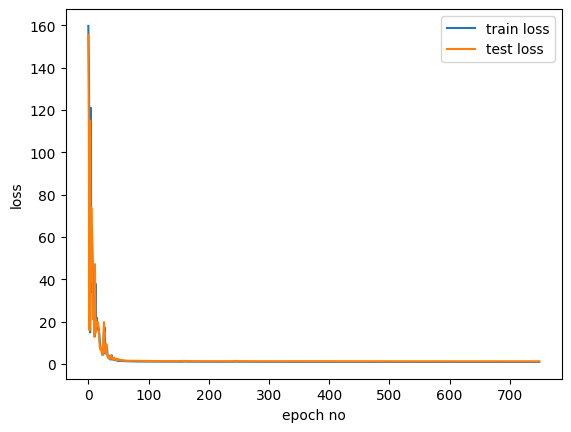

In [ ]:
################ Model Training Evaluation ################
plt.plot(trainLosses, label='train loss')
plt.plot(testLosses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

###########################################################

In [ ]:
#################################################

In [ ]:
#################################################

In [39]:
################ Model TESTING ################
#Checking one-step prediction performance of the model
testTarget = YTest.cpu().detach().numpy()
testPreds = []

for i in range(len(testTarget)):
  input_ = XTest[i].reshape(1, T, D)
  p = lstmModel(input_)[0,0].item()

  # update the predictions list
  testPreds.append(p)

In [40]:
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [41]:
plot_len = len(testPreds)
plot_df = dfDated[['date', 'mean_temp']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = testPreds
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,mean_temp,prediction
date,,
2012-08-27,16.9,17.242685
2012-08-28,19.1,18.943604
2012-08-29,17.1,17.144951
2012-08-30,15.7,14.799494
2012-08-31,12.4,14.570803


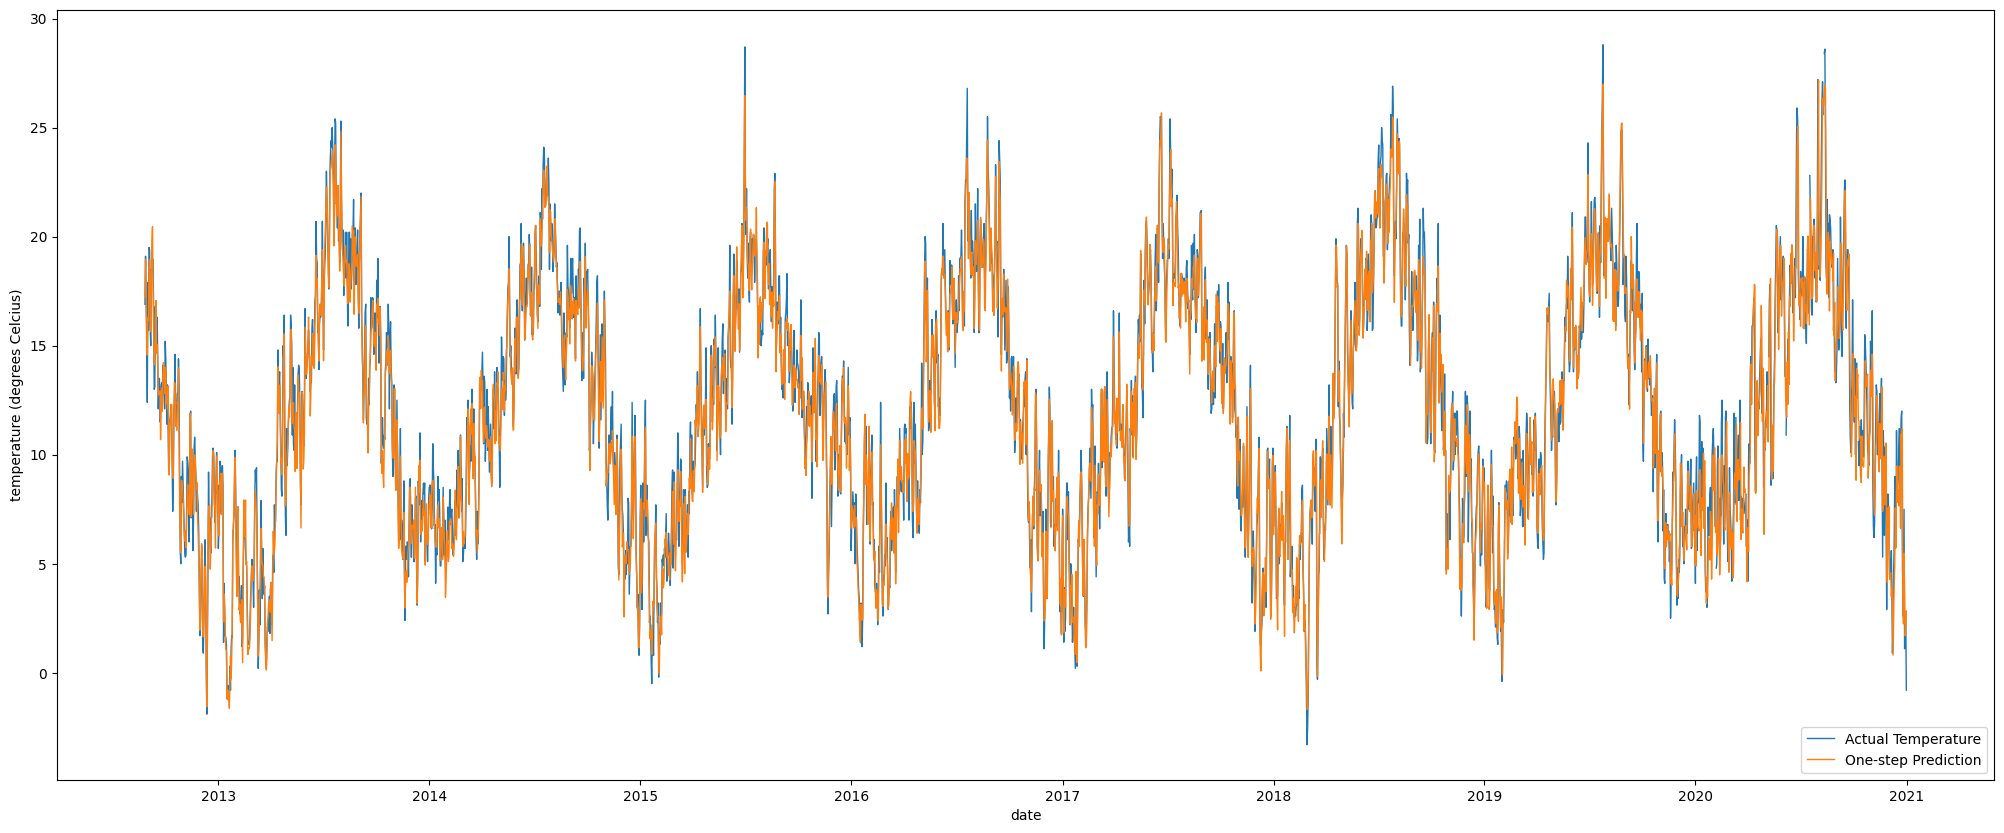

In [42]:
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.plot(plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

In [ ]:
#################################################

In [ ]:
#################### INFERENCING ####################

In [136]:
def compileSet(date, numDays:int = 20):
  dfOriginal = openSet(defaultPath = False)

  vars = preprocess(dfOriginal)
  #XTest, YTest = vars["datasets"][2], vars["datasets"][3]
  T, D, N = vars["dimensions"]["timesteps"], vars["dimensions"]["dimension"], vars["dimensions"]["N"]

  # find the requested instance index in the dataframe
  instance = dfOriginal.index[dfOriginal["date"] == date].to_numpy()[0]
  print("org instance", instance)
  print("last insance", instance+numDays+T)
  print("num days", numDays)
  print("T = ", T)
  lastInstance = int(instance + numDays + T)
  daysToInfer = dfOriginal.iloc[instance:lastInstance]
  print("sample size", daysToInfer.shape[0])
  #daysToInfer = pd.read_csv("asfdg.csv")
  vars = preprocess(daysToInfer, trainPercent = 0.0, timestep = 20) # we set to 0.0 because we want to just split the data into X and Y not training and testing.
  X, Y = vars["datasets"][2], vars["datasets"][3]

  return [X, Y, T, D, N]

#london_weather.csv

def infer(model: lstmAlgorithm, startDate, daysForward = 20):
  if daysForward < 21: raise Exception("daysForward parameter cannot be < 21.")
  #testTarget = YTest.cpu().detach().numpy()
  [X, Y, T, D, N] = compileSet(startDate, daysForward)
  print(X)
  preds = []
  for i in range(len(Y)):
    input_ = X[i].reshape(1, T, D)
    input_ = input_.to(device)
    model.to(device)
    pred = model(input_)[0, 0].item()
    preds.append(pred)
  return [preds, Y]

In [137]:
preds, Y = infer(lstmModel, "2020-12-09", 21)
print(preds)

15341 15341
trainingsize 3049
T 20
setSize 9
org instance 15318
last insance 15359
num days 21
T =  20
sample size 23
23 23
trainingsize 3
T 20
setSize 9
tensor([[[ 0.6946, -0.1159,  0.5282, -0.7297, -0.7115, -0.6208, -0.6677,
           0.2048,  0.0000],
         [ 0.6946, -1.0041, -0.4636, -0.4702, -0.2839, -0.0993,  2.0108,
          -0.3024,  0.0000],
         [ 0.3231, -1.0041, -1.5793,  0.5968,  0.5715,  0.4967, -0.6677,
          -1.3168,  0.0000],
         [-1.5347, -0.9358, -0.0916,  0.2219,  0.4004,  0.5215, -0.6677,
          -0.5278,  0.0000],
         [ 1.0662, -1.0041, -0.2156,  0.5680, -0.3409, -1.0927,  1.1180,
          -0.0287,  0.0000],
         [ 0.3231, -0.6625, -1.5793,  1.0005,  1.1702,  1.1672, -0.2510,
          -0.4071,  0.0000],
         [-1.1631,  0.6357,  0.4043,  0.7121,  0.4574,  0.1738, -0.3701,
           0.0840,  0.0000],
         [ 0.6946,  1.1140,  0.9002,  0.4238,  0.4574,  0.4222,  0.2847,
           0.2692,  0.0000],
         [-0.7916, -0.2525, -0

In [ ]:
#torch.cuda.empty_cache()
#london_weather.csv

In [ ]:
#################################################

In [ ]:
#Checking one-step prediction performance of the model
testTarget = YTest.cpu().detach().numpy()
testPreds = []

for i in range(len(testTarget)):
  input_ = XTest[i].reshape(1, T, D)
  p = lstmModel(input_)[0,0].item()

  # update the predictions list
  testPreds.append(p)